In [75]:
import pandas as pd
import numpy as np
import matplotlib as plt
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.6/dist-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['sign', 'plt']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [76]:
import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader

In [77]:
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score

### Random generation of time series with linear dependencies

In [78]:
length = 100000
train_length = 80000

In [79]:
max_lag = 250
min_number_of_ts = 5
max_number_of_ts = 15
coefficients_scaling = 0.4
number_of_experiments = 10

In [80]:
def generate_timeseries(n_experiments):
    result_ts = []
    targets = []
    configs = []
    for i in range(n_experiments):
        np.random.seed(i*100)
        n_ts = np.random.randint(min_number_of_ts, max_number_of_ts+1)
        X = np.random.randn(length, n_ts)
        regr_dict = {}
        lags_dict = {}
        sign_dict = {}
        coef_dict = {}
        for i in range(n_ts):
            n_coupled = np.random.randint(0, n_ts)
            regressors = np.random.choice(np.arange(0, n_ts), n_coupled, replace=False)
            regr_dict[i] = regressors
            lags = np.random.choice(np.arange(1, max_lag), n_coupled, replace=False)
            lags_dict[i] = lags
            sign_dict[i] = []
            for k in range(n_coupled):
                sign = np.random.randint(0, 2)
                sign = sign*2 - 1
                sign_dict[i].append(sign)
            coefs = np.random.rand(n_coupled)*coefficients_scaling
            coef_dict[i] = coefs
            
        for j in range(length):
            for i in range(n_ts):
                for regr, lag, sign, coef in zip(regr_dict[i], lags_dict[i], sign_dict[i], coef_dict[i]):
                    X[j, i] += sign*coef*X[j-lag, regr]
        result_ts.append(X)
        target = np.random.randint(0, n_ts)
        while len(regr_dict[target]) == 0:
            target = np.random.randint(0, n_ts)
        targets.append(target)
        configs.append([regr_dict, lags_dict, sign_dict, coef_dict])
    return result_ts, targets, configs

In [81]:
import numpy as np

In [82]:
Xs, targets, configs = generate_timeseries(number_of_experiments)

### Examples of generated time series

0 0


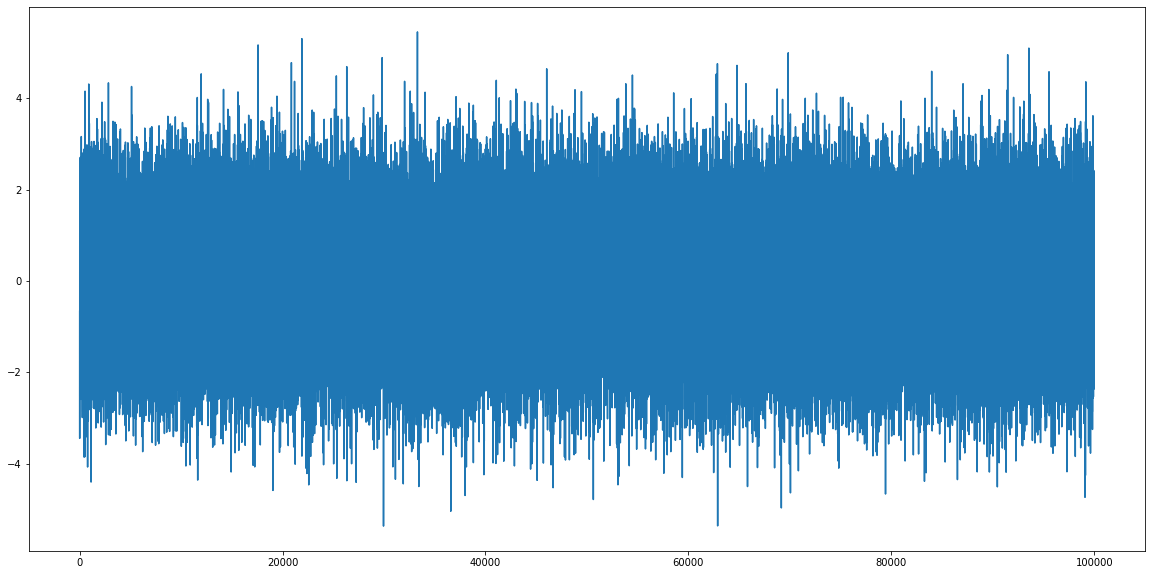

1 0


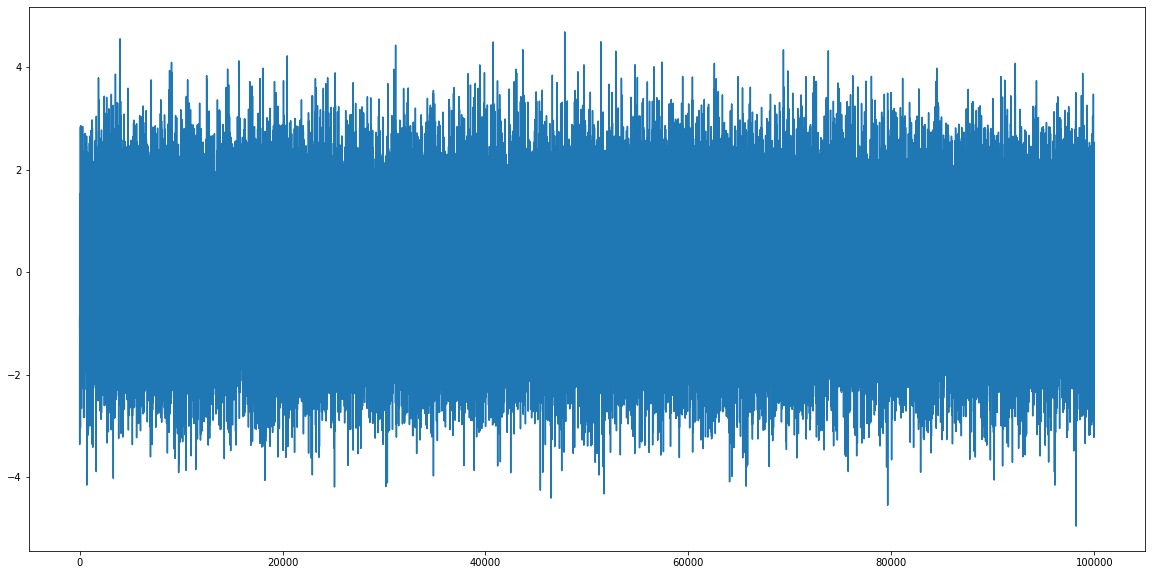

2 0


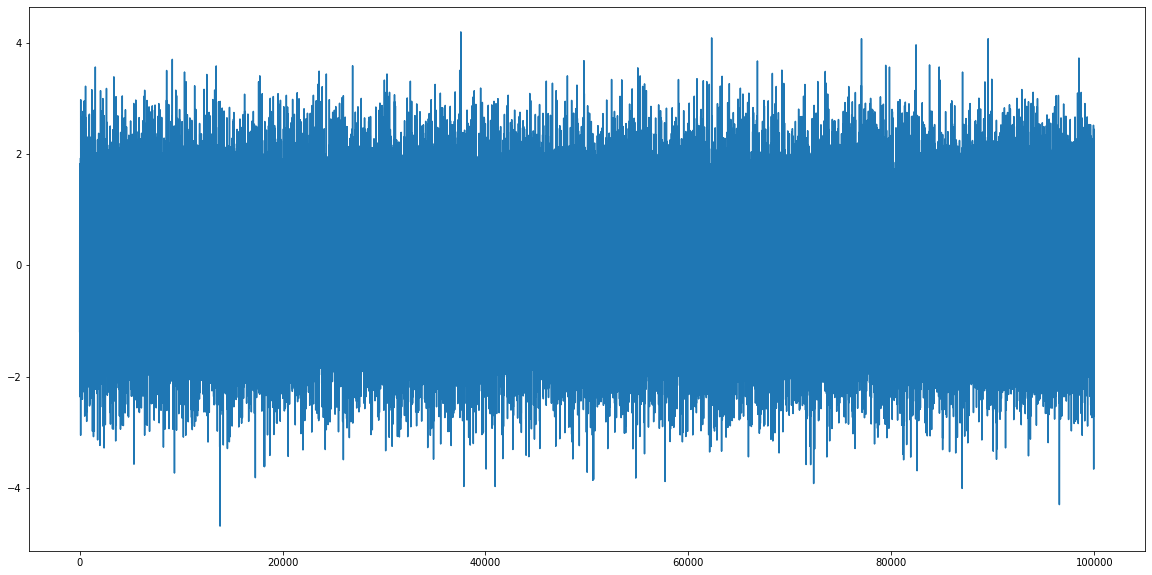

3 0


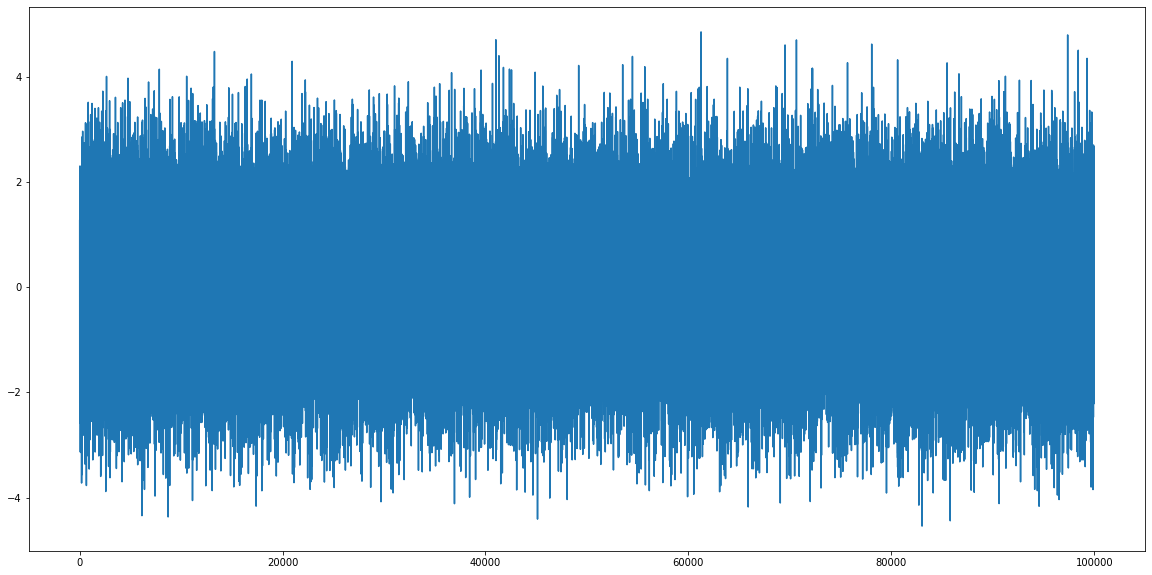

4 0


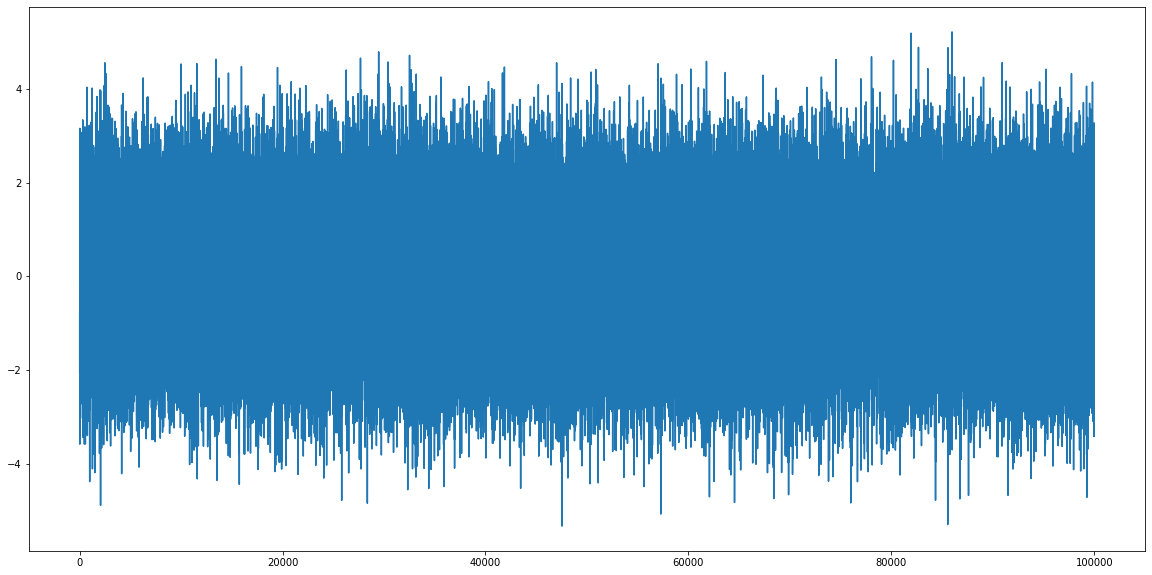

5 0


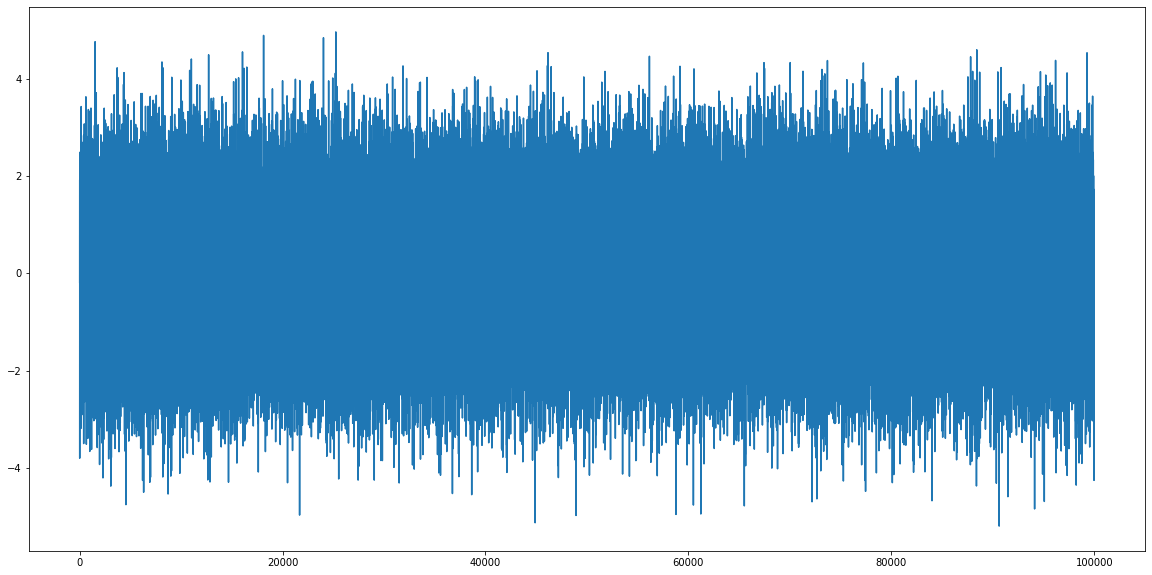

6 0


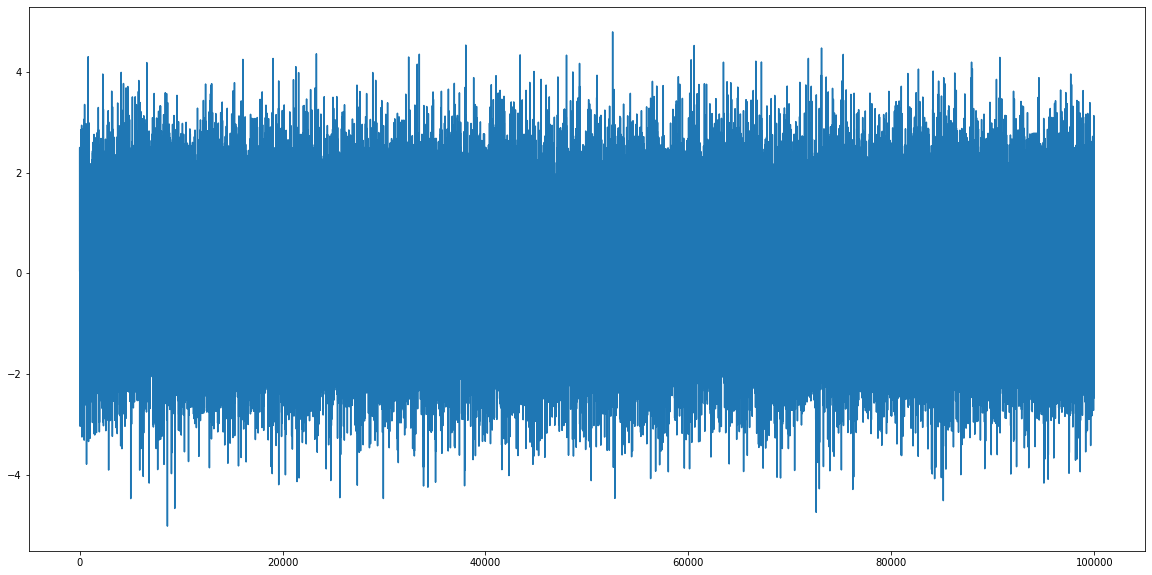

7 0


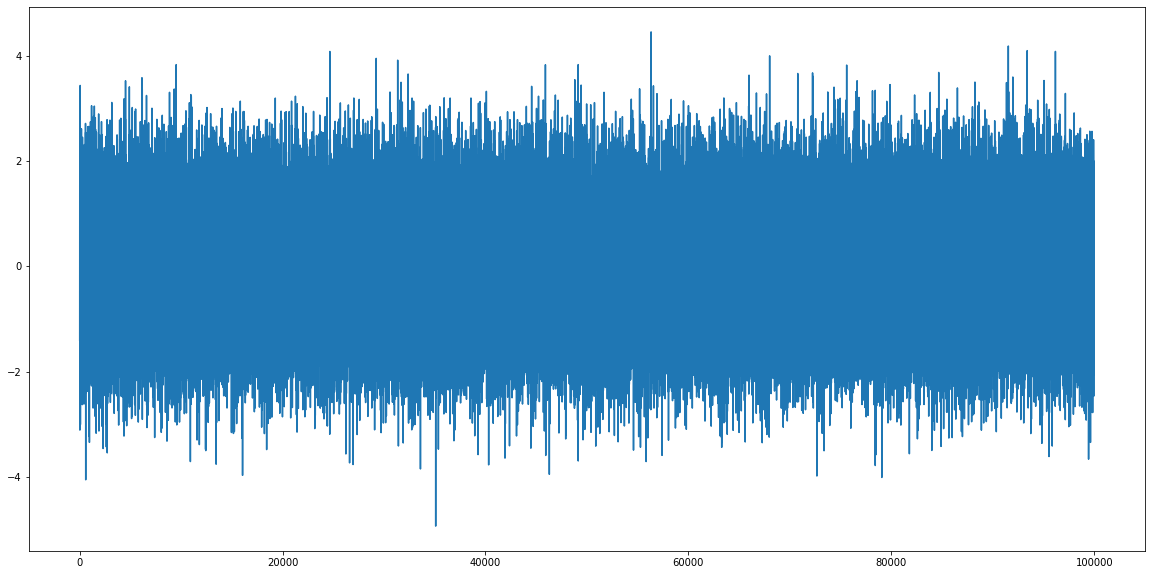

8 0


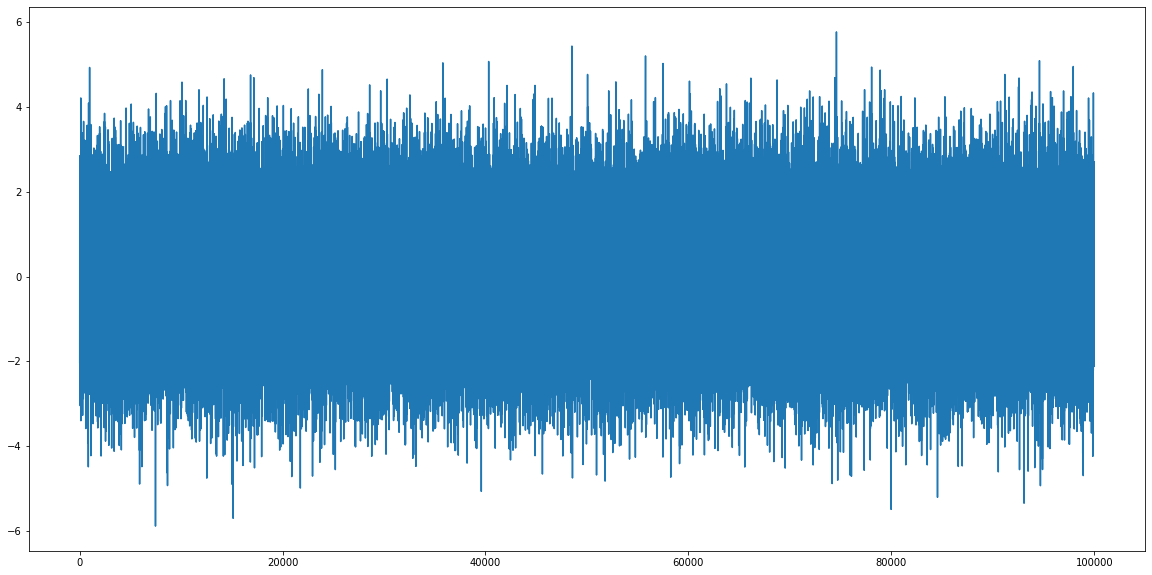

9 0


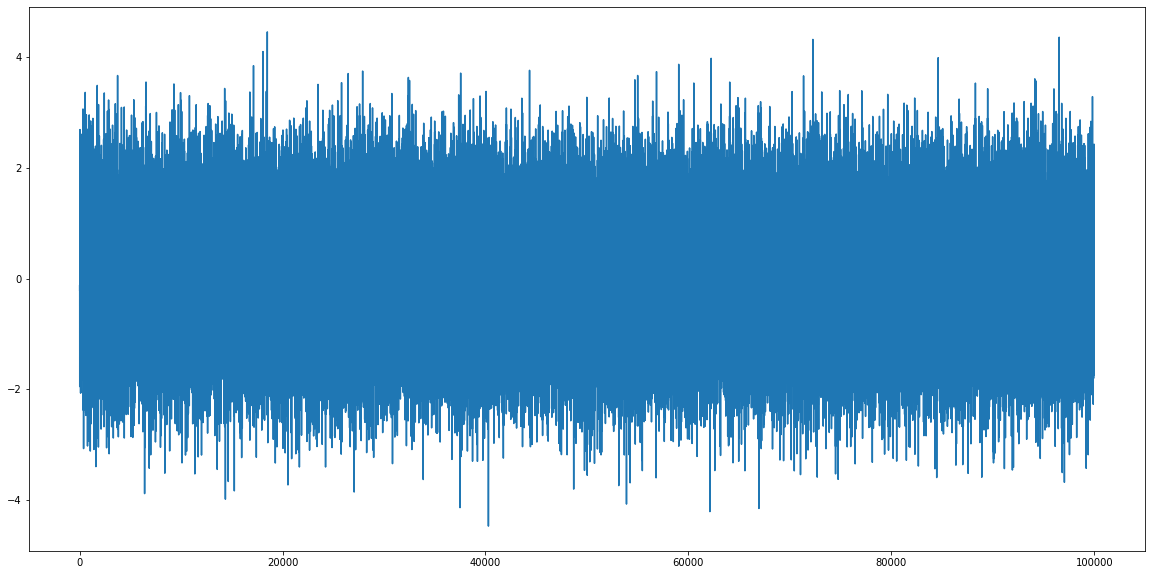

In [83]:
for i in range(len(Xs)):
    for j in range(Xs[i].shape[1]):
        plt.figure(figsize=(20, 10))
        print(i, j)
        plt.plot(Xs[i][:, j])
        plt.show()
        break

### Example of config 

In [84]:
print('Regressors')
print(configs[5][0])
print('Lags')
print(configs[5][1])
print('Signs')
print(configs[5][2])
print('Coefficients')
print(configs[5][3])

Regressors
{0: array([ 5, 11,  9, 14,  7,  1]), 1: array([2]), 2: array([3, 1, 0, 5]), 3: array([12,  5,  2]), 4: array([10,  0,  2, 12,  1,  8,  3, 14,  6]), 5: array([], dtype=int64), 6: array([ 3,  7,  5, 12,  0, 14,  4,  8,  2, 13]), 7: array([ 8,  2,  1,  3, 13]), 8: array([], dtype=int64), 9: array([ 1,  0,  6,  3, 12, 10,  4]), 10: array([ 0, 10,  4, 12]), 11: array([ 3, 14]), 12: array([ 5, 14,  0,  4,  2,  3, 12,  8]), 13: array([ 5,  1,  3, 11,  6,  7]), 14: array([ 7, 13,  4,  9,  5])}
Lags
{0: array([ 58, 106, 159,  97, 221, 204]), 1: array([97]), 2: array([125,  98, 150,  29]), 3: array([195, 210,  78]), 4: array([146, 117, 103, 207, 210, 112, 104,  42, 215]), 5: array([], dtype=int64), 6: array([223,  33,  47,  90,  56, 107, 197, 246, 108,  60]), 7: array([189, 106, 162, 139,  34]), 8: array([], dtype=int64), 9: array([ 64, 215, 171, 208, 168, 221,  28]), 10: array([151,  70, 236, 249]), 11: array([242, 245]), 12: array([249,  87,  93, 246,  89, 160, 128,   5]), 13: array

### Obtained equations

In [85]:
print("Equations obtained")
for k in range(len(configs)):
    print("Case ", k+1)
    for key in configs[k][0].keys():
        eq = "X{} = ".format(key)
        for  regr, ts, sign, coef in zip(configs[k][0][key], configs[k][1][key],
                                         configs[k][2][key], configs[k][3][key]):
            if(sign == 1):
                eq += "+"
            eq += str(sign*round(coef, 3)) + "X{}".format(regr) + "[t-{}]".format(ts) + " "
        eq += "+ n~N(0, 1)"
        print(eq)
        print("")

Equations obtained
Case  1
X0 = +0.129X7[t-249] -0.104X1[t-206] +0.374X4[t-55] -0.334X0[t-140] +0.341X2[t-89] + n~N(0, 1)

X1 = +0.235X1[t-182] +0.129X4[t-205] +0.149X2[t-122] -0.399X6[t-77] + n~N(0, 1)

X2 = -0.012X8[t-184] +0.106X7[t-200] + n~N(0, 1)

X3 = -0.312X6[t-140] -0.374X8[t-246] -0.035X9[t-136] -0.375X7[t-165] +0.072X1[t-60] -0.341X3[t-182] +0.209X4[t-174] +0.162X2[t-5] + n~N(0, 1)

X4 = -0.078X4[t-164] +0.201X3[t-213] -0.187X2[t-147] -0.037X1[t-89] + n~N(0, 1)

X5 = -0.239X8[t-78] -0.269X6[t-197] +0.254X5[t-187] +0.37X2[t-179] +0.1X1[t-69] +0.383X3[t-77] -0.073X9[t-84] +0.253X0[t-152] + n~N(0, 1)

X6 = +0.123X2[t-196] +0.241X5[t-152] + n~N(0, 1)

X7 = -0.267X6[t-221] -0.393X1[t-220] -0.286X4[t-151] -0.075X7[t-126] -0.256X9[t-247] +0.014X0[t-44] + n~N(0, 1)

X8 = +0.157X9[t-43] -0.185X3[t-73] +0.399X4[t-180] +0.199X7[t-131] -0.385X8[t-210] +0.355X0[t-21] + n~N(0, 1)

X9 = +0.103X2[t-86] +0.052X7[t-42] +0.126X1[t-2] + n~N(0, 1)

Case  2
X0 = -0.224X7[t-109] -0.353X1[t-124] +0

### Calculating dependencies for  randomly chosen targets

In [86]:
import torch
import torch.nn as nn
from torch.nn.utils import weight_norm
class TCNTemporalBlock(nn.Module):
    def __init__(self, input_channels, output_channels, kernel_size, dilation):
        super().__init__()
        padding = int(dilation*(kernel_size-1))
        self.pad = nn.ConstantPad1d((padding, 0), 0)
        self.conv1 = weight_norm(nn.Conv1d(input_channels, output_channels, kernel_size, dilation=dilation))
        self.conv2 = weight_norm(nn.Conv1d(output_channels, output_channels, kernel_size, dilation=dilation))
        self.residual = nn.Conv1d(input_channels, output_channels, 1)
        
    def forward(self, x):
        out = self.pad(x)
        out = torch.relu(self.conv1(out))
        out = self.pad(out)
        out = torch.relu(self.conv2(out))
        y = self.residual(x)
        out = torch.relu(out + y)
        return out
    

class LayerWiseAttentionTCN(nn.Module):
    def __init__(self, input_dim, n_layers, n_channels=32, attention_dim=16, kernel_size=3):
        super().__init__()
        self.first_layer = TCNTemporalBlock(input_dim, n_channels, kernel_size, 1)
        self.tcn_layers = nn.ModuleList([TCNTemporalBlock(n_channels, n_channels, kernel_size, 2**(i+1)) for i in range(n_layers-1)])
        self.n_layers = n_layers
        self.W_a = nn.Linear(n_channels, attention_dim)
        self.v_a = nn.Linear(attention_dim, 1)
        self.output_transform = nn.Linear(n_channels, 1)
    def forward(self, x):
        x = x.permute(0, 2, 1)
        xs = []
        x = self.first_layer(x)
        xs.append(x[...,-1])
        for i in range(self.n_layers-1):
            x = self.tcn_layers[i](x)
            xs.append(x[..., -1])
        xs = torch.stack(xs)
        xs = xs.permute(1, 0, 2)
        e_ij = self.v_a(torch.relu(self.W_a(xs)))
        alpha_ij = torch.exp(e_ij)/torch.exp(e_ij).sum(dim=1, keepdim=True)
        out = (xs*alpha_ij).sum(dim=1)
        
        out = self.output_transform(out)
        return out.squeeze(1)

In [87]:
m = TCNTemporalBlock(32, 64, 3, 4)

In [88]:
x = torch.randn(8, 32, 10)

In [89]:
y = m(x)

In [90]:
y.shape

torch.Size([8, 64, 10])

In [91]:
m = LayerWiseAttentionTCN(5, 9)

In [92]:
x = torch.randn(8, 300, 5)

In [93]:
y = m(x)

In [94]:
y.shape

torch.Size([8])

In [95]:
depth = 300
epochs = 100
importance_calculation_steps = 20
early_stopping_epochs = 10

regularizer_coeff1 = 0.005
regularizer_coeff2 = 0.0001
scaling_coeff = 0.5
importance_lr = 0.1
importance_threshold = 0.005

In [96]:
maps = []
results = []

In [97]:
from tqdm import tqdm_notebook

In [98]:
for k in range(len(Xs)):
    print("Case: ", k+1)
    X = np.zeros((length, depth, Xs[k].shape[1]))
    for i in tqdm_notebook(range(Xs[k].shape[1])):
        for j in range(depth):
            X[:, j, i] = pd.Series(Xs[k][:, i]).shift(depth - j - 1).bfill()
    
    y = pd.Series(Xs[k][:, targets[k]]).shift(-1).ffill().values
    
    X_train = X[:train_length]
    X_test = X[train_length:]
    y_train = y[:train_length]
    y_test = y[train_length:]
    
    X_train_t = torch.Tensor(X_train)
    X_test_t = torch.Tensor(X_test)
    y_train_t = torch.Tensor(y_train)
    y_test_t = torch.Tensor(y_test)
    
    train_loader = DataLoader(TensorDataset(X_train_t, y_train_t), shuffle=True, batch_size=64)
    test_loader = DataLoader(TensorDataset(X_test_t, y_test_t), shuffle=False, batch_size=64)
    
    #model = TCNModel(X_train_t.shape[2], num_channels=[32] * 9, kernel_size=3, dropout=0.0).cuda()
    model = LayerWiseAttentionTCN(X_train_t.shape[2], 9).cuda()
    opt = torch.optim.Adam(model.parameters(), lr=0.001)
    sc = torch.optim.lr_scheduler.StepLR(opt, 10, 0.8)
    loss = nn.MSELoss()
    
    
    val_loss = 999
    counter = 0
    
    print("Training")
    for e in range(epochs):
        train_loss = 0
        model.train()
        for batch_x, batch_y in tqdm_notebook(train_loader):
            batch_x = batch_x.cuda()
            batch_y = batch_y.cuda()
            opt.zero_grad()
            output = model(batch_x)
            l = loss(output, batch_y)
            l.backward()
            opt.step()
            train_loss+=l.item()*batch_x.shape[0]
        true = []
        preds = []
        model.eval()
        sc.step()
        with torch.no_grad():
            for batch_x, batch_y in test_loader:
                batch_x = batch_x.cuda()
                output = model(batch_x)
                true.append(batch_y.numpy())
                preds.append(output.detach().cpu().numpy())
        preds = np.concatenate(preds)
        true = np.concatenate(true)
        mse = mean_squared_error(true, preds)
        r2 = r2_score(true, preds)
        print("Iter: ", e, "train: ", train_loss/len(X_train_t), "mse: ", mse, "r2: ", r2)
        if val_loss > mse:
            val_loss = mse
            torch.save(model.state_dict(), "tcn_attn2{}.pt".format(k))
        else:
            counter += 1
        
        if counter == early_stopping_epochs:
            break
    model.load_state_dict(torch.load('tcn_attn2{}.pt'.format(k)))
    
    bce_loss = nn.BCELoss()
    mse_loss = nn.MSELoss()
    
    model.eval()
    
    print("Calculating Importance:")
    importance_map = []
    for batch_x, batch_y in tqdm_notebook(test_loader):
        batch_x = batch_x.cuda()
        #batch_y = batch_y.cuda()
        bx = batch_x
        y = model(batch_x)
        mask = nn.Parameter(-scaling_coeff*torch.randn_like(bx))
        opt = torch.optim.RMSprop(nn.ParameterList([mask]), lr=importance_lr)
        for e in range(importance_calculation_steps):
            opt.zero_grad()
            model.zero_grad()
            model.eval()
            y = y.detach()
            M = torch.sigmoid(mask)
            x_hat = bx*M
            y_hat = model(x_hat)
            l = mse_loss(y_hat, y)
            l += regularizer_coeff1*torch.sum(torch.abs(M))
            ones = torch.zeros_like(bx)
            ones[M>0.5] = 1
            l += 0.5*bce_loss(M, ones)
            l.backward()
            opt.step()
        M = torch.sigmoid(mask)
        #ms = ms.detach().cpu().numpy()
        thresholds = {}
        with torch.no_grad():
            for t in np.linspace(M.min().item(), M.max().item(), 100):
                M_clone = M.clone()
                M_clone[M_clone>t] = 1
                M_clone[M_clone<=t] = 0
                x_hat = bx*M_clone
                y_hat = model(x_hat)
                l = mse_loss(y_hat, y)
                l += regularizer_coeff2*torch.sum(torch.abs(M_clone))
                thresholds[l.item()] = t
        t = thresholds[min(thresholds.keys())]
        M = M.detach().cpu().numpy()
        M[M>t] = 1
        M[M<=t] = 0
        importance_map.append(np.abs(M))
        
    importance_map = np.concatenate(importance_map)
    importance_map = np.mean(importance_map, axis=0)
    
    maps.append(importance_map)
    result = {}
    for i in range(importance_map.shape[1]):
        max_val = importance_map[:, i].max()
        if max_val > importance_threshold:
            timestep = importance_map.shape[0] - np.argmax(importance_map[:, i])
            result[i] = timestep
    
    FP, TP, FN = 0, 0, 0
    for regr, ts in zip(configs[k][0][targets[k]], configs[k][1][targets[k]]):
        predicted_timestep = result.get(regr)
        if predicted_timestep is None:
            FN += 1
        elif predicted_timestep != ts:
            FP += 1
            FN += 1
        else:
            TP += 1

    for regr in result.keys():
        if regr not in configs[k][0][targets[k]]:
            FP += 1
            
    precision = TP/(TP + FP + 1e-9)
    recall = TP/(TP + FN + 1e-9)
    print("Results: ", precision, recall)
    results.append([precision, recall])

Case:  1


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.



Training


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Iter:  0 train:  1.8237515413284302 mse:  1.8239973 r2:  0.010751179415967704


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Iter:  1 train:  1.6643994483947755 mse:  1.4827361 r2:  0.19583490140856852


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Iter:  2 train:  1.4573541305541993 mse:  1.4702293 r2:  0.20261792485652974


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Iter:  3 train:  1.4030384566307068 mse:  1.4393054 r2:  0.2193895782485421


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Iter:  4 train:  1.3717202974319458 mse:  1.398372 r2:  0.24158988203111564


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Iter:  5 train:  1.3621764877796174 mse:  1.3822812 r2:  0.2503168689461197


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Iter:  6 train:  1.3543055443286895 mse:  1.3910295 r2:  0.24557212520565086


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Iter:  7 train:  1.347545469903946 mse:  1.3869529 r2:  0.24778314663443568


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Iter:  8 train:  1.343021824502945 mse:  1.3847636 r2:  0.2489704721275564


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Iter:  9 train:  1.3381265931129456 mse:  1.3898102 r2:  0.2462333919407419


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Iter:  10 train:  1.3258295002937317 mse:  1.3919256 r2:  0.24508613268521995


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Iter:  11 train:  1.3181397233009338 mse:  1.3923934 r2:  0.24483245732404002


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Iter:  12 train:  1.3153429656028748 mse:  1.4019393 r2:  0.23965517916796264


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Iter:  13 train:  1.311741905450821 mse:  1.3917129 r2:  0.2452014516245501


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Iter:  14 train:  1.3060076835632324 mse:  1.4034262 r2:  0.2388487306185142


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Iter:  15 train:  1.3029767689704894 mse:  1.4126626 r2:  0.23383944602862128
Calculating Importance:


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:78: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Results:  0.79999999984 0.4999999999375
Case:  2


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.



Training


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Iter:  0 train:  1.1993424465179443 mse:  1.2116197 r2:  -0.00012598746900471802


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Iter:  1 train:  1.1973091172218322 mse:  1.2122267 r2:  -0.0006270789832492074


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Iter:  2 train:  1.1952301526546478 mse:  1.2116325 r2:  -0.00013659426334489133


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Iter:  3 train:  1.1923284130096437 mse:  1.213504 r2:  -0.0016812636994101293


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Iter:  4 train:  1.1333957273960114 mse:  1.079575 r2:  0.10886984641113062


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Iter:  5 train:  1.051549601149559 mse:  1.0734131 r2:  0.11395595197481456


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Iter:  6 train:  1.0409872500419617 mse:  1.0760304 r2:  0.1117956250174057


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Iter:  7 train:  1.0338477293491364 mse:  1.0771221 r2:  0.11089450092693853


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Iter:  8 train:  1.0284139230251312 mse:  1.0795029 r2:  0.10892922610498523


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Iter:  9 train:  1.0197526921749116 mse:  1.0867455 r2:  0.10295096624053779


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Iter:  10 train:  1.0086068449497223 mse:  1.0945739 r2:  0.0964889731001578


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Iter:  11 train:  0.9997530253410339 mse:  1.0916629 r2:  0.09889185619607055


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Iter:  12 train:  0.9923611575603485 mse:  1.1001153 r2:  0.09191480286818043
Calculating Importance:


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:78: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Results:  0.9999999989999999 0.3333333332222222
Case:  3


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.



Training


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Iter:  0 train:  1.5846016492843629 mse:  1.558951 r2:  0.030911477014842648


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Iter:  1 train:  1.5559035383224487 mse:  1.5549616 r2:  0.03339146965097306


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Iter:  2 train:  1.546941004705429 mse:  1.5501088 r2:  0.036408094356142895


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Iter:  3 train:  1.5406515946865083 mse:  1.5486416 r2:  0.037320181082932224


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Iter:  4 train:  1.5328435933113098 mse:  1.5522434 r2:  0.03508114414339192


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Iter:  5 train:  1.428475703382492 mse:  1.3225907 r2:  0.17783979439511866


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Iter:  6 train:  1.278597543334961 mse:  1.2836089 r2:  0.20207205406968942


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Iter:  7 train:  1.232272828578949 mse:  1.2879168 r2:  0.19939408582332852


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Iter:  8 train:  1.2037085333824158 mse:  1.2446029 r2:  0.22631930487386853


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Iter:  9 train:  1.1824393280506134 mse:  1.245009 r2:  0.22606682953087642


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Iter:  10 train:  1.1560325076580047 mse:  1.2487131 r2:  0.22376420980471112


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Iter:  11 train:  1.14899327917099 mse:  1.2370942 r2:  0.23098694136458564


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Iter:  12 train:  1.1409985438346864 mse:  1.244627 r2:  0.22630428320534002


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Iter:  13 train:  1.1334499760627748 mse:  1.2385465 r2:  0.23008413622516877


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Iter:  14 train:  1.1253896060943605 mse:  1.2527161 r2:  0.2212759481476888


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Iter:  15 train:  1.1186248157978058 mse:  1.2459023 r2:  0.22551140544433723


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Iter:  16 train:  1.1111759910583496 mse:  1.2641746 r2:  0.21415291114760693


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Iter:  17 train:  1.1037550168514252 mse:  1.2632066 r2:  0.2147546577759336
Calculating Importance:


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:78: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Results:  0.9999999998 0.35714285711734695
Case:  4


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.



Training


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Iter:  0 train:  1.1356155047893524 mse:  1.1258135 r2:  0.013543329609086885


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Iter:  1 train:  1.1232825798511505 mse:  1.0894065 r2:  0.04544380104058254


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Iter:  2 train:  1.0792593813896179 mse:  1.0789583 r2:  0.054598720682304314


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Iter:  3 train:  1.0712686792373658 mse:  1.0773808 r2:  0.0559809750464042


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Iter:  4 train:  1.0692730758190154 mse:  1.0808184 r2:  0.05296887204842515


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Iter:  5 train:  1.067835638332367 mse:  1.0752647 r2:  0.057835174446376425


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Iter:  6 train:  1.0648280916690827 mse:  1.0755798 r2:  0.057558926782607434


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Iter:  7 train:  1.0626741622924805 mse:  1.0776137 r2:  0.055776860966846864


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Iter:  8 train:  1.05989066426754 mse:  1.0796938 r2:  0.05395428628228205


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Iter:  9 train:  1.056190927696228 mse:  1.0793571 r2:  0.05424920133173394


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Iter:  10 train:  1.0511984556674958 mse:  1.0808648 r2:  0.0529281172906102


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Iter:  11 train:  1.0472055881261826 mse:  1.0949702 r2:  0.04056879703588234


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Iter:  12 train:  1.0423764055728912 mse:  1.0886253 r2:  0.046128355852260494


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Iter:  13 train:  1.037578783941269 mse:  1.0901242 r2:  0.04481486745086605


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Iter:  14 train:  1.0350575652837752 mse:  1.0919499 r2:  0.04321522111780618
Calculating Importance:


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:78: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Results:  0.9999999989999999 0.3333333332222222
Case:  5


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.



Training


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Iter:  0 train:  1.0007205735206604 mse:  1.0030198 r2:  -0.00019047941528849144


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Iter:  1 train:  0.9996284292221069 mse:  1.0031568 r2:  -0.00032699973507654967


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Iter:  2 train:  0.998477418756485 mse:  1.0042744 r2:  -0.0014413985010381936


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Iter:  3 train:  0.9965958158493042 mse:  1.007133 r2:  -0.004292102529138031


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Iter:  4 train:  0.9937056578159332 mse:  1.0104748 r2:  -0.007624319530473933


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Iter:  5 train:  0.9896939803123475 mse:  1.013493 r2:  -0.010634092042868915


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Iter:  6 train:  0.9836712637424468 mse:  1.0187755 r2:  -0.015901732392065382


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Iter:  7 train:  0.9770584710597991 mse:  1.0223818 r2:  -0.01949777195856628


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Iter:  8 train:  0.9683841950893403 mse:  1.0275872 r2:  -0.024688531614298848


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Iter:  9 train:  0.9594886102676392 mse:  1.0410299 r2:  -0.03809343404148402


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Iter:  10 train:  0.9451940402507782 mse:  1.0539888 r2:  -0.0510155819151874
Calculating Importance:


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:78: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Results:  0.0 0.0
Case:  6


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.



Training


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Iter:  0 train:  1.3946573700904845 mse:  1.4058472 r2:  -0.0003059295042893151


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Iter:  1 train:  1.3931030212402344 mse:  1.4058257 r2:  -0.00029071551698867104


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Iter:  2 train:  1.3915308104038238 mse:  1.4071937 r2:  -0.001263928834950745


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Iter:  3 train:  1.3885476024627685 mse:  1.4075124 r2:  -0.0014907078595303158


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Iter:  4 train:  1.3835760079860688 mse:  1.4110044 r2:  -0.0039754096129829275


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Iter:  5 train:  1.3697111604213714 mse:  1.3719105 r2:  0.023841230812780334


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Iter:  6 train:  1.318054743719101 mse:  1.3612462 r2:  0.03142917757459396


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Iter:  7 train:  1.2968357135295867 mse:  1.3542802 r2:  0.03638570224830129


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Iter:  8 train:  1.2812302474021913 mse:  1.3642397 r2:  0.02929916562333812


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Iter:  9 train:  1.2665554647922517 mse:  1.3567804 r2:  0.03460668179951454


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Iter:  10 train:  1.246217554616928 mse:  1.3700228 r2:  0.02518432483620192


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Iter:  11 train:  1.2317321627616882 mse:  1.389559 r2:  0.01128360552160157


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Iter:  12 train:  1.219098302078247 mse:  1.3758315 r2:  0.021051212137047415


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Iter:  13 train:  1.2047330761909485 mse:  1.3989927 r2:  0.004571303667521898


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Iter:  14 train:  1.1928009672164916 mse:  1.3955086 r2:  0.007050353270982357
Calculating Importance:


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:78: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Results:  0.9999999989999999 0.19999999996
Case:  7


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.



Training


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Iter:  0 train:  1.1280798528194427 mse:  1.125158 r2:  -0.0004900612575364782


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Iter:  1 train:  1.126989270591736 mse:  1.1249732 r2:  -0.0003258539605326405


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Iter:  2 train:  1.1261707060813904 mse:  1.1261783 r2:  -0.0013973367826183303


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Iter:  3 train:  1.124769754266739 mse:  1.1279224 r2:  -0.0029482498806123747


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Iter:  4 train:  1.1218112295627594 mse:  1.1287824 r2:  -0.0037130262249245316


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Iter:  5 train:  1.1171787707328797 mse:  1.1359236 r2:  -0.010062879479112219


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Iter:  6 train:  1.1111777481079101 mse:  1.1384434 r2:  -0.0123034436853795


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Iter:  7 train:  1.1036862876415252 mse:  1.1474063 r2:  -0.020273416668602495


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Iter:  8 train:  1.0947897764205932 mse:  1.1507668 r2:  -0.023261491894536857


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Iter:  9 train:  1.0843429567337035 mse:  1.1755203 r2:  -0.04527225708740268


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Iter:  10 train:  1.0680780626773834 mse:  1.1929985 r2:  -0.06081389820957184


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Iter:  11 train:  1.0557332030296325 mse:  1.190365 r2:  -0.05847218585334768
Calculating Importance:


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:78: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Results:  0.0 0.0
Case:  8


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.



Training


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Iter:  0 train:  1.616432221031189 mse:  1.5342238 r2:  0.047800432593880005


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Iter:  1 train:  1.5017213428974152 mse:  1.472793 r2:  0.08592681520142764


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Iter:  2 train:  1.4728372563838958 mse:  1.4634457 r2:  0.09172809476326305


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Iter:  3 train:  1.455129767560959 mse:  1.4584429 r2:  0.09483303873641191


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Iter:  4 train:  1.4433763227462768 mse:  1.4614372 r2:  0.09297468436770151


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Iter:  5 train:  1.4348440522670747 mse:  1.4630475 r2:  0.0919752718707505


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Iter:  6 train:  1.4273503339767457 mse:  1.4687248 r2:  0.08845166227166801


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Iter:  7 train:  1.4178796735286712 mse:  1.4635279 r2:  0.09167710124244244


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Iter:  8 train:  1.4113531811714173 mse:  1.4797915 r2:  0.08158323516160981


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Iter:  9 train:  1.4038588814735413 mse:  1.4696356 r2:  0.08788633909907362


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Iter:  10 train:  1.3879380737781524 mse:  1.4766448 r2:  0.08353631106758463


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Iter:  11 train:  1.3780480669498443 mse:  1.4841872 r2:  0.07885511105451881


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Iter:  12 train:  1.367957033252716 mse:  1.491234 r2:  0.07448162407015535


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Iter:  13 train:  1.3565085796356202 mse:  1.4890754 r2:  0.07582135990830807
Calculating Importance:


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:78: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Results:  0.499999999875 0.24999999996875
Case:  9


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.



Training


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Iter:  0 train:  1.6996540863990783 mse:  1.5914735 r2:  0.1842330055827881


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Iter:  1 train:  1.5888386497974396 mse:  1.6029735 r2:  0.17833826620672455


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Iter:  2 train:  1.5776680613040923 mse:  1.5946106 r2:  0.1826249328259988


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Iter:  3 train:  1.56843713927269 mse:  1.6025584 r2:  0.1785509616948583


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Iter:  4 train:  1.5596790750980378 mse:  1.6044302 r2:  0.17759159175859784


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Iter:  5 train:  1.5518265201568604 mse:  1.6046748 r2:  0.1774661431279192


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Iter:  6 train:  1.5420173388957978 mse:  1.6107937 r2:  0.17432975480064872


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Iter:  7 train:  1.5330541964054107 mse:  1.6071796 r2:  0.17618219443771854


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Iter:  8 train:  1.5238091398239135 mse:  1.6132803 r2:  0.1730551324041768


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Iter:  9 train:  1.5151245987415314 mse:  1.6208456 r2:  0.16917722255612777


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Iter:  10 train:  1.4990145694732666 mse:  1.6251763 r2:  0.1669574238649274
Calculating Importance:


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:78: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Results:  0.9999999995 0.18181818180165288
Case:  10


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.



Training


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Iter:  0 train:  1.3452431117534638 mse:  1.3428644 r2:  -0.0001276181676335142


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Iter:  1 train:  1.3367499572753907 mse:  1.2526469 r2:  0.0670638490050266


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Iter:  2 train:  1.1699651131629945 mse:  1.1651459 r2:  0.13223220626447407


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Iter:  3 train:  1.1428502638816833 mse:  1.1623505 r2:  0.13431408593725258


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Iter:  4 train:  1.1373503634929656 mse:  1.1435704 r2:  0.14830097189793578


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Iter:  5 train:  1.1322098519802093 mse:  1.1413777 r2:  0.1499341865497924


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Iter:  6 train:  1.1279799124717713 mse:  1.1657162 r2:  0.1318074804446001


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Iter:  7 train:  1.1237073357582092 mse:  1.1452466 r2:  0.1470526219888023


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Iter:  8 train:  1.1196048280239106 mse:  1.1465296 r2:  0.14609708461286275


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Iter:  9 train:  1.1161908201217652 mse:  1.1530136 r2:  0.14126811226991587


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Iter:  10 train:  1.107177175807953 mse:  1.1673365 r2:  0.13060080558263987


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Iter:  11 train:  1.1017192525863648 mse:  1.1647408 r2:  0.13253386737831063


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Iter:  12 train:  1.0971711899280547 mse:  1.1624187 r2:  0.13426329362833633


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Iter:  13 train:  1.093710718536377 mse:  1.1818882 r2:  0.11976299109392863


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Iter:  14 train:  1.086881681585312 mse:  1.1828394 r2:  0.11905457173104772


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Iter:  15 train:  1.0819520963668823 mse:  1.189421 r2:  0.11415276901134286
Calculating Importance:


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:78: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Results:  0.9999999995 0.499999999875


In [99]:
for i, r in enumerate(results):
    print('Case {}'.format(i+1))
    print('Precision', 'Recall')
    print(r)

Case 1
Precision Recall
[0.79999999984, 0.4999999999375]
Case 2
Precision Recall
[0.9999999989999999, 0.3333333332222222]
Case 3
Precision Recall
[0.9999999998, 0.35714285711734695]
Case 4
Precision Recall
[0.9999999989999999, 0.3333333332222222]
Case 5
Precision Recall
[0.0, 0.0]
Case 6
Precision Recall
[0.9999999989999999, 0.19999999996]
Case 7
Precision Recall
[0.0, 0.0]
Case 8
Precision Recall
[0.499999999875, 0.24999999996875]
Case 9
Precision Recall
[0.9999999995, 0.18181818180165288]
Case 10
Precision Recall
[0.9999999995, 0.499999999875]


### Visual estimation of resulted importance heatmaps


Case 1


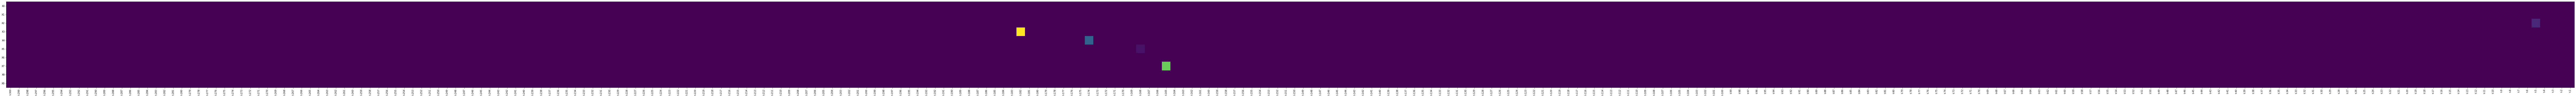

Case 2


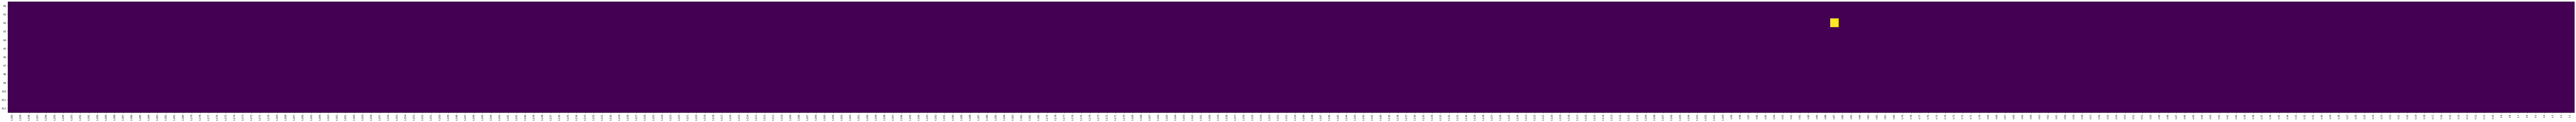

Case 3


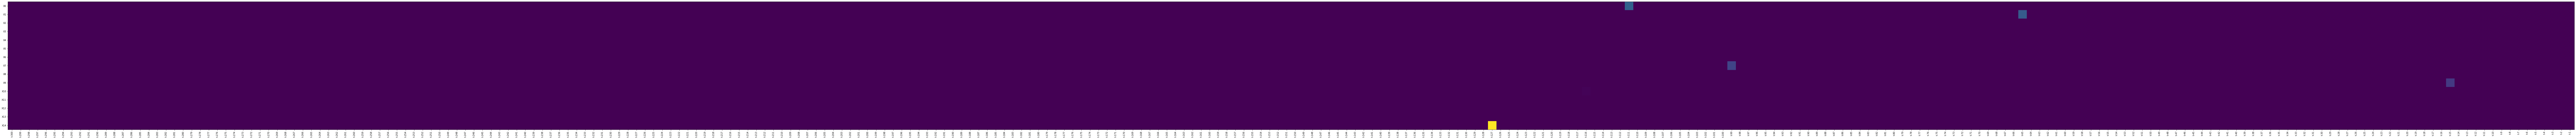

Case 4


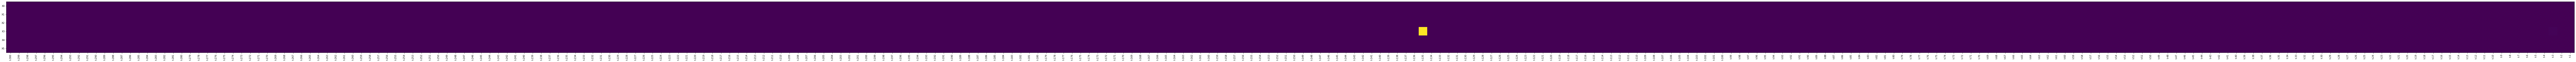

Case 5


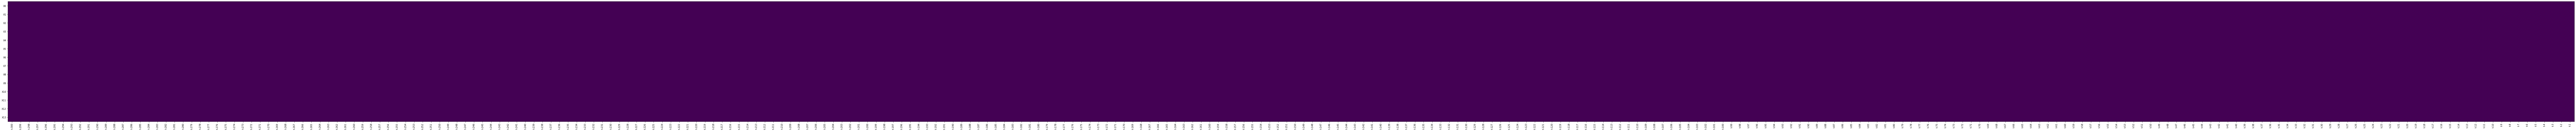

Case 6


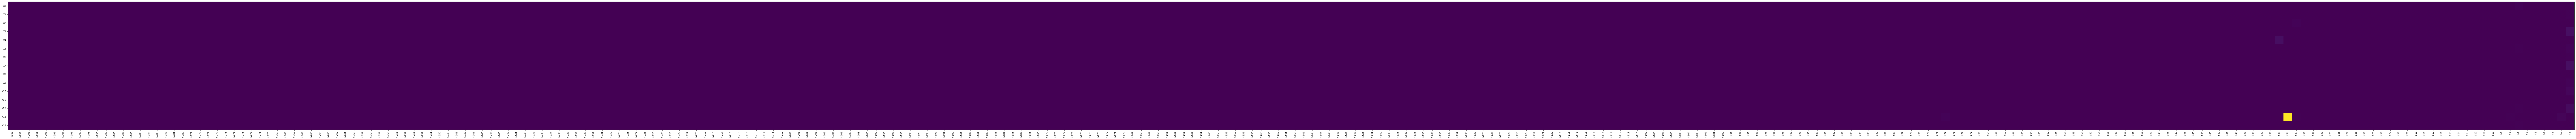

Case 7


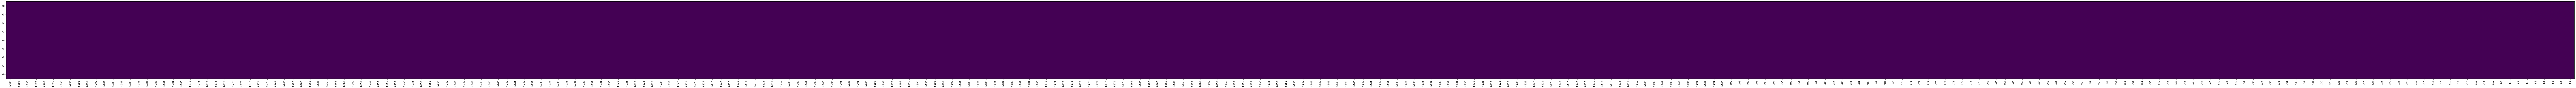

Case 8


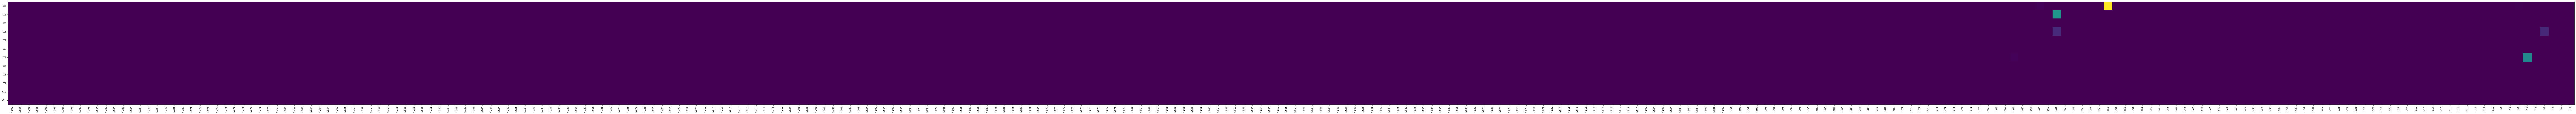

Case 9


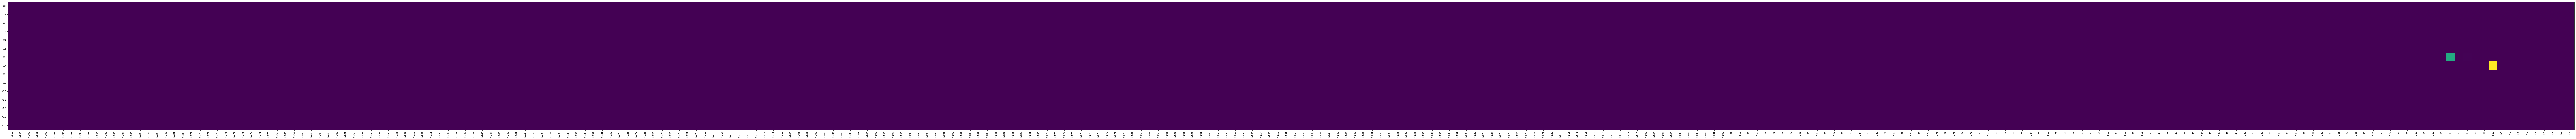

Case 10


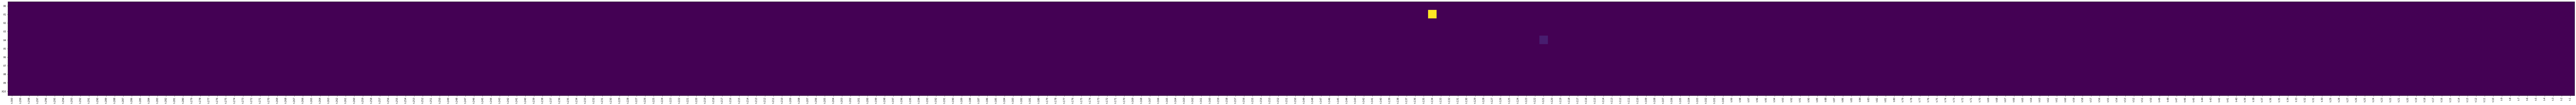

In [101]:
for i in range(number_of_experiments):
    print('Case {}'.format(i+1))
    fig, ax = plt.subplots(figsize=(200, 100))
    ax.imshow(maps[i].T)
    ax.set_xticks(np.arange(depth))
    ax.set_xticklabels(["t-{}".format(i) for i in range(depth,0,-1)], rotation=90)
    ax.set_yticks(np.arange(Xs[i].shape[1]))
    ax.set_yticklabels(["X{}".format(i) for i in range(Xs[i].shape[1])])
    plt.show()